# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
 -1
 -1
 -1
 -1
  1
  1
  1
  1
  1
 -1
  ⋮
  1
  1
 -1
 -1
  1
  1
 -1
  1
  1

### We create a function to visualize the data

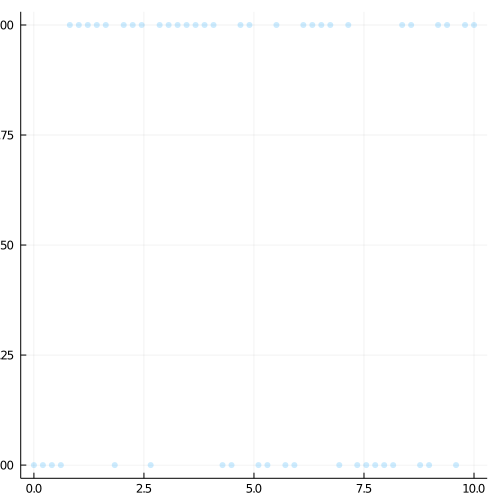

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.997190 seconds (1.87 M allocations: 106.829 MiB, 99.55% compilation time)


(Variational Gaussian Process with a Bernoulli Likelihood with Logistic Link infered by Analytic Variational Inference , (local_vars = (c = [0.9564044341780387, 0.8461803471705062, 0.7257520600883187, 0.6351415753653372, 0.6210886891857208, 0.6925682176228456, 0.8105563137364451, 0.933489800926917, 1.038922119489601, 1.1202067754215643  …  0.7805262837121671, 0.7235539931084173, 0.6580133207775908, 0.611280918130406, 0.6055232564981703, 0.6431961212980014, 0.7078522165982866, 0.7797485638993401, 0.8456629664143649, 0.8990584168962216], θ = [0.2325390052334934, 0.2360788340855258, 0.2395754826715185, 0.24192146892932068, 0.24226187989009404, 0.24046439265647176, 0.23715568611084667, 0.2332995535324841, 0.22970150533707853, 0.22676801705336574  …  0.2380362236597894, 0.23963539917340662, 0.24135372705495867, 0.24249561376139953, 0.24263134357251467, 0.24172345767774184, 0.24005915448823473, 0.23805868938545124, 0.23609471855101866, 0.23441854791670125]), opt_state = (NamedTuple(),), hype

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:42
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:54
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:55
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:26
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:09
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:57
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:49
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:43
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:38
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:34
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:31
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:28
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-1.1831479188336749, -0.7834616569924759, -0.31206142945367576, 0.1909296093416418, 0.7166095748151008, 1.1954517955317943, 1.6707352479654642, 2.0481649587343753, 2.3896255157361006, 2.612133292852229  …  -0.7501567414890146, -0.818090172013098, -0.8014382554719337, -0.6750555414735335, -0.499315086157773, -0.3386132903086811, -0.16557010228225577, -0.029288980790692365, 0.07569708146527032, 0.1573108279351224]]
 [[-0.051467159817008334, -0.09838208694703954, -0.07343332176074568, -0.06230228199031894, -0.03484174302953921, -0.020447082796029636, 0.006726197471779383, 0.05543245531384189, 0.1544645494987137, 0.29887732590743  …  -0.9288243002657122, -0.7607919942213559, -0.49194161325714614, -0.1599003563027538, 0.20625137597150234, 0.5367304276016172, 0.831791591417337, 1.0348344005320662, 1.142172642765744, 1.175603798759446]]
 [[0.3684189462602019, 0.6122887135344314, 0.8436815838207915, 1.0960051298766544, 1.3320550456761573, 1.5411

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

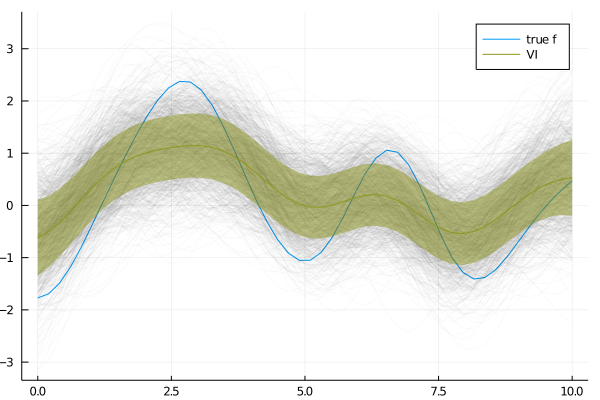

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

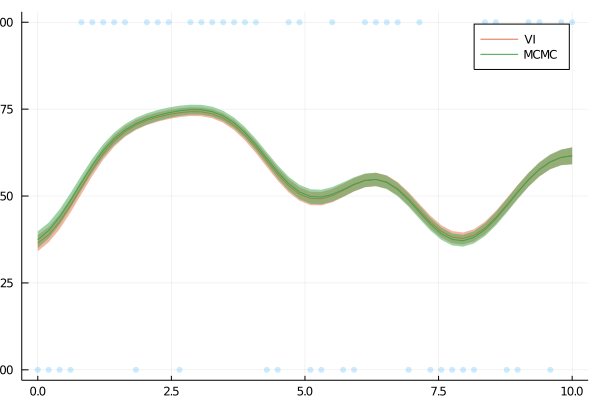

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*